Supuestoa tener en cuenta:
* Se supone que la relacion entre el error u y la V.A X_i tiene que ser 0, o sumamente cercano a 0. (por error de aleatorialidad)
* Se supone que los errores en promedio tienen que tender a 0 (buscamos minizarlo obviamente)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os
import seaborn as sns



<h1> Analisis de emiciones CO2 </h1>

In [2]:
#  ==== OBTENCION DE DATOS

# Obtén la ruta absoluta del arhivo actual
current_dir = os.getcwd() 

path_datasets = os.path.join(current_dir,"datasets")


path_co2 = os.path.join(path_datasets,"CO2 Emissions.csv") 

#Construimos el dataframe
base = pd.read_csv(path_co2)
nombres_nuevos = ['marca','modelo','clase','tamanio_motor','cilindros','transmision','combus_tipo','consumo_ciudad','consumo_autopista','consumo_comb','consumo_comb_mpg','emisiones_co2']
base.columns = nombres_nuevos

base

,marca,modelo,clase,tamanio_motor,cilindros,transmision,combus_tipo,consumo_ciudad,consumo_autopista,consumo_comb,consumo_comb_mpg,emisiones_co2
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29,232
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27,240
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29,232


Analisis descriptivo basico

In [3]:
n = base.shape[0]

co2_media = base['emisiones_co2'].mean()
co2_std = base['emisiones_co2'].std()

print(f'El número de observaciones es: {n}')
print(f'El nivel de emisiones promedio es: {co2_media}')
print(f'El desvío estandar es: {co2_std}')
print(f'Y el coeficiente de variación es: {co2_std/co2_media*100}%')

El número de observaciones es: 7385
El nivel de emisiones promedio es: 250.58469871360867
El desvío estandar es: 58.512679394406476
Y el coeficiente de variación es: 23.35045982248109%


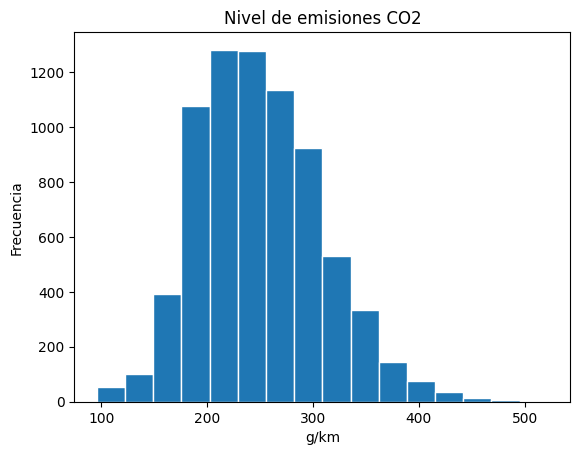

In [4]:
plt.hist(base['emisiones_co2'], bins=16, edgecolor = "white")
plt.title('Nivel de emisiones CO2')
plt.xlabel('g/km')
plt.ylabel('Frecuencia')
plt.show()

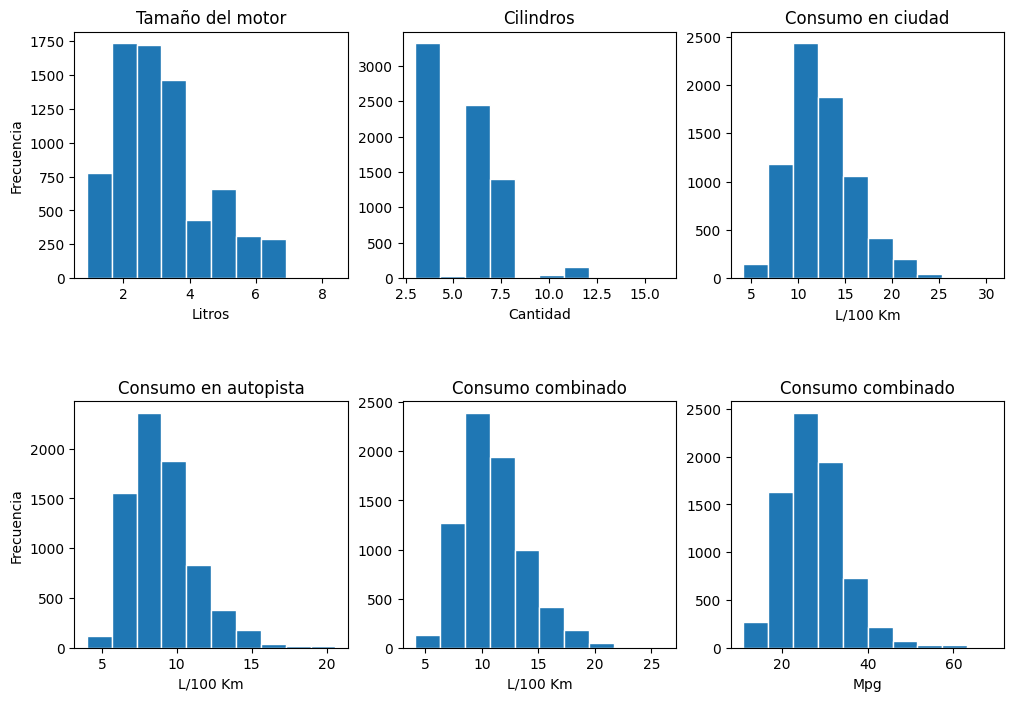

In [5]:
variables = ['tamanio_motor','cilindros','consumo_ciudad','consumo_autopista','consumo_comb','consumo_comb_mpg']
titulos = ['Tamaño del motor', 'Cilindros', 'Consumo en ciudad', 'Consumo en autopista','Consumo combinado','Consumo combinado']
xs = ['Litros','Cantidad','L/100 Km','L/100 Km','L/100 Km','Mpg']
ys = ['Frecuencia',None, None,'Frecuencia',None, None]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for i in range(2):
  for j in range(3):
    ax[i,j].hist(base[variables[i*3+j]], edgecolor = "white")
    ax[i,j].set_title(titulos[i*3+j])
    ax[i,j].set_xlabel(xs[i*3+j])
    ax[i,j].set_ylabel(ys[i*3+j])

plt.subplots_adjust(hspace=0.5)
plt.show()

<Axes: >

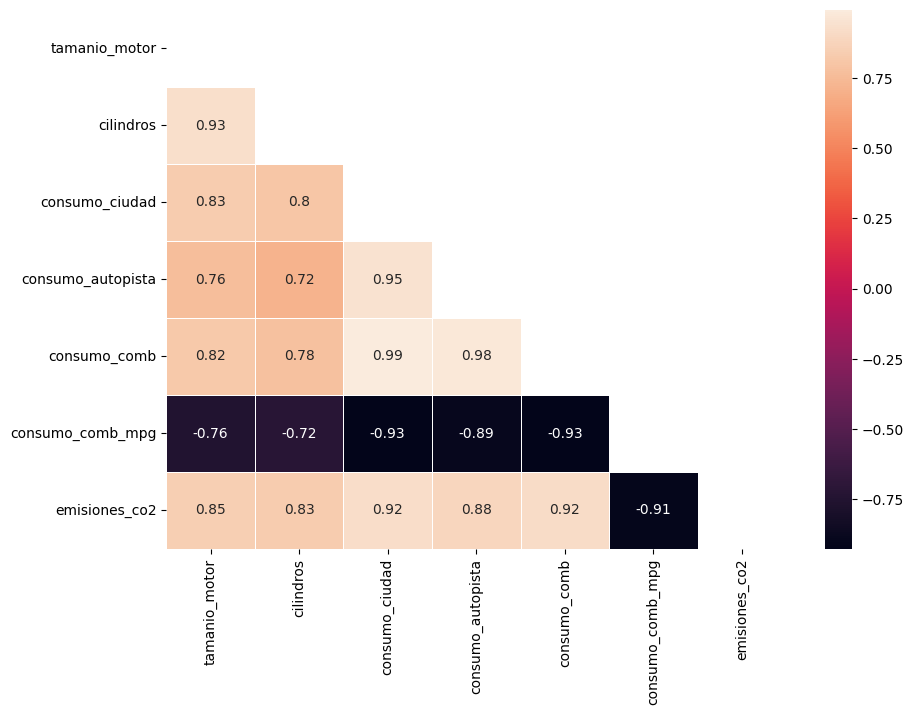

In [6]:
# Calcular la matriz de correlación
corr = base.select_dtypes(include='number').corr()

# Crear una máscara para la mitad superior
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize = (10,7))
#Dibujar el mapa de calor con la máscara
sns.heatmap(corr, mask=mask, annot=True, cmap='rocket', linewidths=0.5)

Si hacemos un scatter entre el tamaño del motor y las emisiones, podemos ver que a medida que aumenta el tamaño, relativamente aumenta la emision de CO2, esto tiene sentido logico.

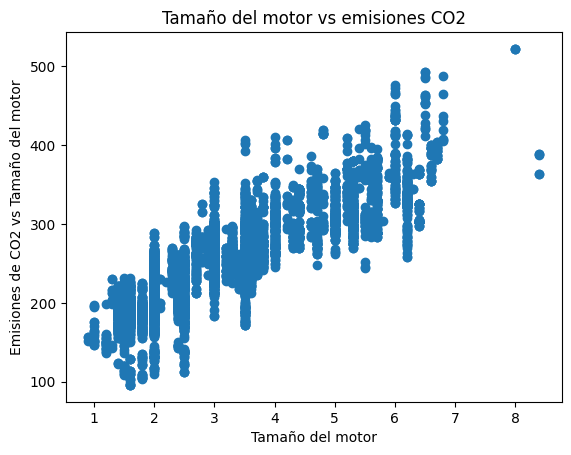

In [7]:
plt.scatter(base['tamanio_motor'], base['emisiones_co2'])
plt.title('Tamaño del motor vs emisiones CO2')
plt.xlabel('Tamaño del motor')
plt.ylabel('Emisiones de CO2 vs Tamaño del motor')
plt.show()


<p> Realizando lo mismo pero teniendo en cuenta el consumo que hay en la ciudad, obtendremos una relaciones "separadas" de la variable X e Y.</p>
En este caso, si nosotros condicionaramos la variable X, entonces obtendriamos posiblemente algun tipo de regresion distinta.


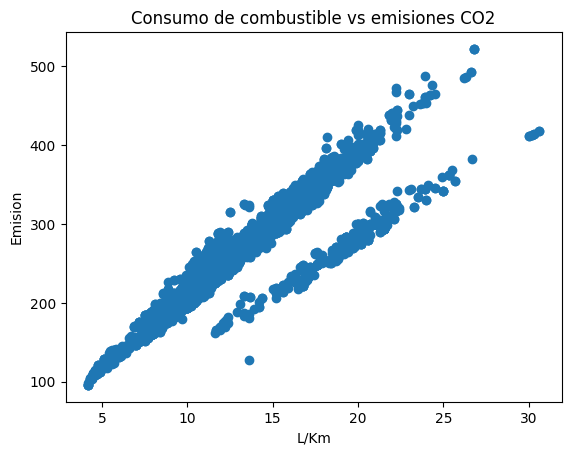

In [8]:
plt.scatter(base['consumo_ciudad'], base['emisiones_co2'])
plt.title('Consumo de combustible vs emisiones CO2')
plt.xlabel('L/Km')
plt.ylabel('Emision')
plt.show()

<h1> Regresiones por distintos metodos </h1>

Utilizando statsmodelos

In [9]:
X = base['consumo_ciudad']
X = sm.add_constant(X)
y = base['emisiones_co2']

#El comando OLS declara una regresion LINEAL que buscara el mejor valor de beta1 utilizando el metodo de minimos cuadrados ordinados. Recordar que en este caso
#Se busca minimizar la suma de los errores (u) que existe entre los valores estimativos y los reales.

reg1 = sm.OLS(y,X).fit()
print(reg1.summary())

"""
Explicacion de algunas salidas:

- Columna coef: es el valor de b_0 y b_1. Son los coeficientes de la regresion.

- Columna std err: es el error estandar de los cieficientes. representan cuanto desvio existe del valor. es decir por ejemplo
    que b_1 presenta un posible error de +- 0.996. 

- Intervalo del 95% de confianza: Representa un intervalo del 95% de confianza de que los coeficientes se encuentre entre -2. ee <= b_i <= +2. ee

"""

                            OLS Regression Results                            
Dep. Variable:          emisiones_co2   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 4.045e+04
Date:                Fri, 14 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:24:42   Log-Likelihood:                -33630.
No. Observations:                7385   AIC:                         6.726e+04
Df Residuals:                    7383   BIC:                         6.728e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             57.5599      0.996     57.

'\nExplicacion de algunas salidas:\n\n- Columna coef: es el valor de b_0 y b_1. Son los coeficientes de la regresion.\n\n- Columna std err: es el error estandar de los cieficientes. representan cuanto desvio existe del valor. es decir por ejemplo\n    que b_1 presenta un posible error de +- 0.996. \n\n- Intervalo del 95% de confianza: Representa un intervalo del 95% de confianza de que los coeficientes se encuentre entre -2. ee <= b_i <= +2. ee\n\n'

In [10]:
X = base["consumo_ciudad"].values.reshape(-1, 1)
y = base["emisiones_co2"].values

model = LinearRegression().fit(X, y)

y_pred = model.predict(X)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print('Coeficiente:', model.coef_) #Es el valor del beta 1. 
print('Intercepto:', model.intercept_) #Valor de beta 0.
print('Error cuadrático medio:', mse)
print('R^2:', r2)

Coeficiente: [15.37245896]
Intercepto: 57.55990260166175
Error cuadrático medio: 528.3806361133411
R^2: 0.8456503198972763


Prediccion usando el primer modelo creado

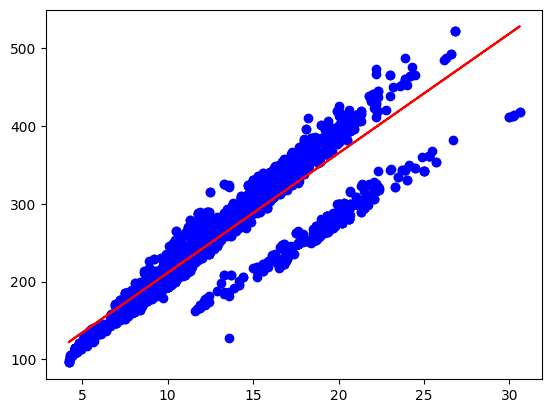

In [11]:
#Estamos haciendo una prediccion del CO2, y predicimos los valores de la Y en este caso usando los valores de 'consumo_ciudad'
predicciones = reg1.predict(sm.add_constant(base['consumo_ciudad']))

plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.plot(base['consumo_ciudad'], predicciones, label='Valores predichos', color='red')
plt.show()

Realizamos el mismo grafico pero ahora añadiendo los intervalos de confianza que sostiene la pendiente

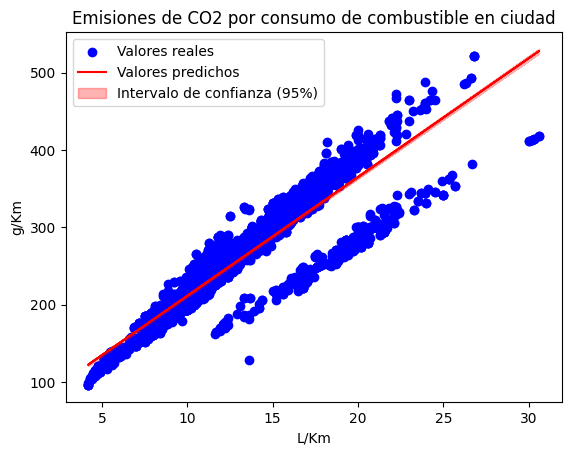

In [12]:
preds = reg1.get_prediction(sm.add_constant(base['consumo_ciudad']))
preds_media = preds.predicted_mean
int_confianza = preds.conf_int()

plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.plot(base['consumo_ciudad'], preds_media, label='Valores predichos', color='red')
plt.fill_between(base['consumo_ciudad'], int_confianza[:, 0], int_confianza[:, 1], color='red', alpha=0.3, label='Intervalo de confianza (95%)')
plt.xlabel('L/Km')
plt.ylabel('g/Km')
plt.title('Emisiones de CO2 por consumo de combustible en ciudad')
plt.legend()
plt.show()

Vemos que la regresión ajusta dentron de todo bien pero como que hay dos grupos al menos. Esto podemos solucionarlo con dummies, en este caso del tipo de combustible, pero lo haremos en un rato con la regresión múltiple.

In [13]:
X = base.select_dtypes(include='number').drop('emisiones_co2', axis=1) #Tomamos las variables numericas
X = sm.add_constant(X) #Agregamos las variables como "features" en el modelo
y = base['emisiones_co2'] #Variable objetivo

reg_total = sm.OLS(y,X).fit()
print(reg_total.summary())

                            OLS Regression Results                            
Dep. Variable:          emisiones_co2   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 1.157e+04
Date:                Fri, 14 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:24:42   Log-Likelihood:                -31880.
No. Observations:                7385   AIC:                         6.377e+04
Df Residuals:                    7378   BIC:                         6.382e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               227.8928      4.20

<p>Pareciera haber un caso de multicolinealidad como cabría esperar entre consumo en ciudad, en autopista y el combinado, lo que termina por afectar la inferencia de los coeficientes.</p>

Una posible solucion es elimnar la variable que combina los tipos de consumo.
<hr>
Recordatorio: la multicolinealidad es la alta correlaccion entre variables. Esto afecta de mala manera al calculo de los coeficientes. Ademas no nos permite estudiar de una forma mas "precisa" la causalidad individual que tiene cada variable.
<hr>
Nota: podemos ver en el caso anterior en consumo_comb como el valor t obtenido es "cercano" a 0. Por eso vemos un valor relativamente alto en el valor P. Esto indica la probabilidad de equivocarnos si tomaramos la alternativa.

In [14]:
X = base.select_dtypes(include='number').drop(['emisiones_co2','consumo_comb'], axis=1)
X = sm.add_constant(X)

reg_total = sm.OLS(y,X).fit()
print(reg_total.summary())

                            OLS Regression Results                            
Dep. Variable:          emisiones_co2   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 1.388e+04
Date:                Fri, 14 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:24:42   Log-Likelihood:                -31880.
No. Observations:                7385   AIC:                         6.377e+04
Df Residuals:                    7379   BIC:                         6.381e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               227.9495      4.19

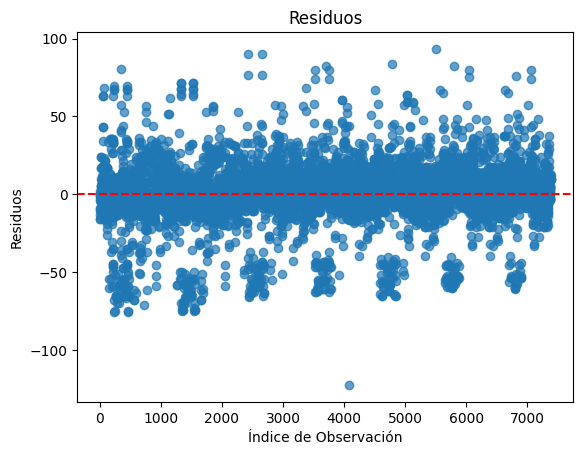

In [15]:
residuos = reg_total.resid
plt.scatter(range(len(residuos)), residuos, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuos')
plt.xlabel('Índice de Observación')
plt.ylabel('Residuos')
plt.show()

esto es una linea de los residuos en general, y por teoria el promedio de estos tendria que ser 0, o sumamente "cercano".

In [16]:
residuos.mean()

1.6305632838826771e-13

Vemos como se cumple el supuesto que el error no depende de las variables X

In [17]:
for var_x in X.columns.drop('const'):

    cov = np.cov(base[var_x],residuos)[0,1]
    print(f"El nivel de covarianza con la variable {var_x} es: {cov}")

El nivel de covarianza con la variable tamanio_motor es: -3.8975155112457326e-13
El nivel de covarianza con la variable cilindros es: -5.04185113064702e-13
El nivel de covarianza con la variable consumo_ciudad es: -1.1403787508619522e-12
El nivel de covarianza con la variable consumo_autopista es: -7.039222942351414e-13
El nivel de covarianza con la variable consumo_comb_mpg es: 2.301203888573079e-12


Ahora vamos a hacer una prediccion con el modelo entrenado con multiples variables. Vamos a ver que ya no trabajamos con una "linea" recta, sino con una serie de puntos que siguen una linea mas o menos.

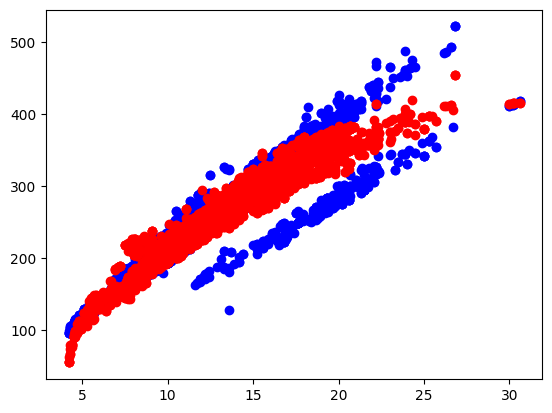

In [18]:
predicciones = reg_total.predict(X)

plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.scatter(base['consumo_ciudad'], predicciones, label='Valores predichos', color='red')

Si bien el modelo aparenta predecir bastante bien, podemos notar cierta diferencia como si hubiera dos grupos. Esto se puede deber a que no incluimos una variable importante como ser el tipo de combustible.
<hr>
Vamos a probar ahora el mismo analisis pero usando la estrategia de las variables categoricas dummies. Donde tomamos una var. categorica de n categoria, y creamos n-1 columnas con valores binarios que representan una categoria. Tiene que ser n-1, ya que si agregamos las n variables podemos sufrir un problema de multicolinealidad perfecta 

In [20]:
base['combus_tipo'].value_counts()

combus_tipo
X    3637
Z    3202
E     370
D     175
N       1
Name: count, dtype: int64

Podemos tomar la categoria X como referencia, y transformamos las demas. N la ignoramos ya que existe solo un caso.

In [21]:
base['combus_Z'] = base['combus_tipo'].apply(lambda x: 1 if x == 'Z' else 0)
base['combus_E'] = base['combus_tipo'].apply(lambda x: 1 if x == 'E' else 0)
base['combus_D'] = base['combus_tipo'].apply(lambda x: 1 if x == 'D' else 0)

base

,marca,modelo,clase,tamanio_motor,cilindros,transmision,combus_tipo,consumo_ciudad,consumo_autopista,consumo_comb,consumo_comb_mpg,emisiones_co2,combus_Z,combus_E,combus_D
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196,1,0,0
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221,1,0,0
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136,1,0,0
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255,1,0,0
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30,219,1,0,0
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29,232,1,0,0
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27,240,1,0,0
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29,232,1,0,0


Probamos la prediccion  ahora. Vemos que no agregamos la variable categorica, ya que se supone que aquel registro que presenta la categoria usada como referencia, mostrara en sus filas una serie de 0.

In [22]:
X = base[['tamanio_motor','cilindros','consumo_ciudad','consumo_autopista','consumo_comb_mpg','combus_Z','combus_E','combus_D']]
X = sm.add_constant(X)

reg_total = sm.OLS(y,X).fit()
print(reg_total.summary())

                            OLS Regression Results                            
Dep. Variable:          emisiones_co2   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.223e+05
Date:                Fri, 14 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:28:55   Log-Likelihood:                -22453.
No. Observations:                7385   AIC:                         4.492e+04
Df Residuals:                    7376   BIC:                         4.499e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                54.0094      1.32

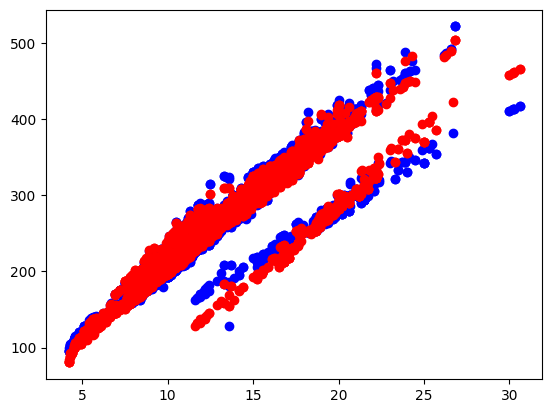

In [23]:
predicciones = reg_total.predict(X)

plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.scatter(base['consumo_ciudad'], predicciones, label='Valores predichos', color='red')

<p> Ahorra vamos a probar el metodo de interaccion </p>
<p>Este consiste en tomar una variable en particular para estudiarla, y multiplicarla por las variables dummies que estemos usando.</p>

<p> nueva_variable = var. binaria * var_a_estudiar </p>

<hr>
Para que sirve esto? hasta ahora vimos que una variable independiente tiene cierto efecto sobre una variable Y dependiente. Con esta nueva estrategia podemos evaluar el nivel en que afecta la presencia de una de las categorias sobre la variable INdependiente. Y a su vez, el efecto que esta causa sobre la variable DEpendiente.

In [24]:
base['combus_Z_ciudad'] = base['combus_Z'] * base['consumo_ciudad']
base['combus_E_ciudad'] = base['combus_E'] * base['consumo_ciudad']
base['combus_D_ciudad'] = base['combus_D'] * base['consumo_ciudad']
base

,marca,modelo,clase,tamanio_motor,cilindros,transmision,combus_tipo,consumo_ciudad,consumo_autopista,consumo_comb,consumo_comb_mpg,emisiones_co2,combus_Z,combus_E,combus_D,combus_Z_ciudad,combus_E_ciudad,combus_D_ciudad
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196,1,0,0,9.9,0.0,0.0
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221,1,0,0,11.2,0.0,0.0
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136,1,0,0,6.0,0.0,0.0
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255,1,0,0,12.7,0.0,0.0
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244,1,0,0,12.1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30,219,1,0,0,10.7,0.0,0.0
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29,232,1,0,0,11.2,0.0,0.0
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27,240,1,0,0,11.7,0.0,0.0
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29,232,1,0,0,11.2,0.0,0.0


In [27]:
X = base[['tamanio_motor','cilindros','consumo_ciudad','consumo_autopista','consumo_comb_mpg','combus_Z','combus_E','combus_D','combus_Z_ciudad','combus_E_ciudad','combus_D_ciudad']]
X = sm.add_constant(X)

reg_total = sm.OLS(y,X).fit()
print(reg_total.summary())

predicciones = reg_total.predict(X)

                            OLS Regression Results                            
Dep. Variable:          emisiones_co2   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.346e+05
Date:                Fri, 14 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:35:00   Log-Likelihood:                -18889.
No. Observations:                7385   AIC:                         3.780e+04
Df Residuals:                    7373   BIC:                         3.788e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.9263      1.06

Interpretacion de esta salida: 
- La variable const en este caso representa la ordena de origen cuando la variable asume el valor categorico que se uso como referencia. En este caso el combustible de tipo X.
<hr>
Ademas de esto, las otras variables (combus_Z_ciudad y las demas) representa el CAMBIO QUE HAY SOBRE EL CONSUMO DE CIUDAD RESPECTO DE LA PENDIENTE (la inclinacion), cuando alguna de estas categorias esta presente.
<hr>
Recordatorio: las variables categoricas dummies representa un cambio de ORDENADA DE ORIGEN sobre la constante.

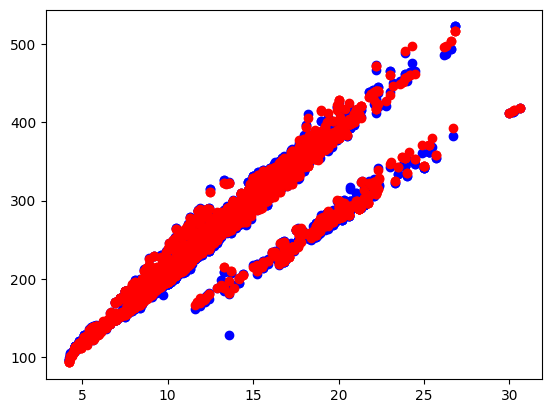

In [26]:
plt.scatter(base['consumo_ciudad'], base['emisiones_co2'], label='Valores reales', color='blue')
plt.scatter(base['consumo_ciudad'], predicciones, label='Valores predichos', color='red')

La presencio ha mejorado a grandes niveles